# Python入門第4回_（医用機械学習入門の手引き追記版）<div style="text-align: right; font-size: 50%;">2021年6月29日火曜日18:00-19:30</div>

台湾の院内心肺停止患者796名の臨床的情報と退院時の神経学的予後のデータ(https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202938 )から前回作成した`cpa_data_preprocessed.csv`を使って、実際に臨床情報から患者の退院時の神経学的予後を予測する機械学習モデルを作成したいと思います。

## 1.  Numpyの紹介

実際にモデル作成の工程に移る前に、numpyモジュールのndarrayというデータ形式について説明します。numpyは数値計算を効率的に行うためのモジュールであり、行列計算をはじめとした計算操作に非常に便利なモジュールです。そこで主に扱われるndarray形式のデータは、今回直接計算には使いませんが、Pythonを用いた機械学習領域では頻用されること、今回の機械学習モジュールでも返り値がndarray形式で返されることがあることから、簡単に紹介しておきます。  

まず、下記のセルでnumpyライブラリをnpという名前でインポートします。

In [1]:
import numpy as np

練習用にtest_listというリストデータ型のオブジェクトを作ります。

In [2]:
test_list = [0, 1, 2, 3, 4, 5]

In [3]:
print(test_list)

[0, 1, 2, 3, 4, 5]


In [4]:
type(test_list)

list

numpyのarray関数を使って、test_listをndarrayというデータ型のオブジェクトに作り替えてみます。

In [5]:
test_list_np = np.array(test_list)

In [6]:
print(test_list_np)

[0 1 2 3 4 5]


In [7]:
type(test_list_np)

numpy.ndarray

リストデータ型のオブジェクトとndarrayオブジェクトについて計算上の違いを確認してみます。

まずリストデータ型で簡単な演算子を使ってみます。

In [8]:
test_list + test_list

[0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]

In [9]:
test_list * 2

[0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]

リスト同士は掛け算できません。下記を実行するとエラーが出ます。

In [10]:
test_list * test_list

TypeError: can't multiply sequence by non-int of type 'list'

次にndarrayで簡単な演算子を使ってみます。ndarrayでは要素同士の計算をしてくれます。

In [11]:
test_list_np + test_list_np

array([ 0,  2,  4,  6,  8, 10])

In [12]:
test_list_np * 2

array([ 0,  2,  4,  6,  8, 10])

In [13]:
test_list_np * test_list_np

array([ 0,  1,  4,  9, 16, 25])

ndarrayはreshapeメソッドで変形することができます。

In [14]:
test_list_np_reshape = test_list_np.reshape(2,3)
test_list_np_reshape

array([[0, 1, 2],
       [3, 4, 5]])

ndarrayは`.shape`メソッドで次元数を確認できます。

In [15]:
test_list_np_reshape.shape

(2, 3)

ndarrayはどんな次元数であっても、計算するndarray同士の次元数があっていれば要素同士の計算をしてくれます。

In [16]:
test_list_np_reshape * test_list_np_reshape

array([[ 0,  1,  4],
       [ 9, 16, 25]])

ndarrayは`.T`で転置できます。

In [17]:
test_list_np_reshape.T

array([[0, 3],
       [1, 4],
       [2, 5]])

ndarrayは、計算するndarray同士の次元数が異なっていても、いずれかの次元が合致していれば他の足りない部分まで自動で補完して要素同士の計算をしてくれます。下は3行2列のデータと1行2列のデータの掛け算です。

In [18]:
test_list_np_reshape.T * np.array([1, 10])

array([[ 0, 30],
       [ 1, 40],
       [ 2, 50]])

**練習問題1**：numpyのarray関数を使って、配列`[0, 1, 2]`と`[3, 4, 5]`をそれぞれ等しい位置にある整数どうしを掛け合わせて並べた配列を作成してください。

In [19]:
np.array([0, 1, 2]) * np.array([3, 4, 5])

array([ 0,  4, 10])

## 2. 機械学習(教師あり学習)による予測モデル作成

機械学習とは、データからパターンを機械的に抽出させ、それによってアルゴリズムを作成させる手法です。その中でも教師あり学習と呼ばれる方法は、既存の答えの分かっているデータから予測モデルを作成する際に利用されます。

### 2-1. 機械学習のためのデータ分割

ここからは前回前処理を行って作成した`cpa_data_preprocessed.csv`を使って、機械学習を行って予測モデルを作っていきます。データフレームを使うため、まずpandasをimportし、pd.read_csv関数を使って`cpa_data_preprocessed.csv`をデータフレーム形式で読み込みます。

In [20]:
import pandas as pd  

In [21]:
df = pd.read_csv('cpa_data_preprocessed.csv')

読み込んだdfを表示してみます。

In [22]:
df

,Age,Male,Respiratory insufficiency,Renal insufficiency,Arrhythmia,Diabetes mellitus,Hypotension,"Heart failure, prior admission","Heart failure, this admission","Myocardial infarction, prior admission",...,Year of Arrest_2009,Year of Arrest_2010,Year of Arrest_2011,Year of Arrest_2012,Year of Arrest_2013,Year of Arrest_2014,Initial cardiac arrest rhythm_1,Initial cardiac arrest rhythm_2,Arrest location_1,Arrest location_2
0,65,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1,59,1,1,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,1,0
2,85,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,90,1,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,97,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,76,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,87,0,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
793,52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
794,57,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


`df.info()`で概観を再度確認します。

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 48 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Age                                                  796 non-null    int64  
 1   Male                                                 796 non-null    int64  
 2   Respiratory insufficiency                            796 non-null    int64  
 3   Renal insufficiency                                  796 non-null    int64  
 4   Arrhythmia                                           796 non-null    int64  
 5   Diabetes mellitus                                    796 non-null    int64  
 6   Hypotension                                          796 non-null    int64  
 7   Heart failure, prior admission                       796 non-null    int64  
 8   Heart failure, this admission                        796 non-null    i

#### 2-1-1. ラベルデータの分離

予測したいターゲットはPrognosisのカラムの情報です。Prognosisのカラム以外の情報を使ってPrognosisを予測するというモデルを作っていきます。そのために、まずデータフレームを「Prognosis以外のカラム」と「Prognosisのカラム」に分ける必要があります。

Prognosis以外の全てのカラムを持ったデータフレームは下記のように作成できます。

In [24]:
df.drop('Prognosis', axis=1)

,Age,Male,Respiratory insufficiency,Renal insufficiency,Arrhythmia,Diabetes mellitus,Hypotension,"Heart failure, prior admission","Heart failure, this admission","Myocardial infarction, prior admission",...,Year of Arrest_2009,Year of Arrest_2010,Year of Arrest_2011,Year of Arrest_2012,Year of Arrest_2013,Year of Arrest_2014,Initial cardiac arrest rhythm_1,Initial cardiac arrest rhythm_2,Arrest location_1,Arrest location_2
0,65,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1,59,1,1,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,1,0
2,85,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,90,1,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,97,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,76,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,87,0,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
793,52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
794,57,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


**練習問題2**：Prognosis以外の全てのカラムを持ったデータフレーム`df.drop('Prognosis', axis=1)`を`X`という変数に代入してください。

In [25]:
X = df.drop('Prognosis', axis=1)

`X.info()`でPrognosisのカラムがなくなっているか、確認しておきます。

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 47 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Age                                                  796 non-null    int64  
 1   Male                                                 796 non-null    int64  
 2   Respiratory insufficiency                            796 non-null    int64  
 3   Renal insufficiency                                  796 non-null    int64  
 4   Arrhythmia                                           796 non-null    int64  
 5   Diabetes mellitus                                    796 non-null    int64  
 6   Hypotension                                          796 non-null    int64  
 7   Heart failure, prior admission                       796 non-null    int64  
 8   Heart failure, this admission                        796 non-null    i

次に「Prognosisのカラム」だけを抜き出します。

In [27]:
df['Prognosis']

0      0
1      0
2      0
3      0
4      0
      ..
791    0
792    1
793    0
794    0
795    0
Name: Prognosis, Length: 796, dtype: int64

**練習問題3**：Prognosisのカラム`df['Prognosis']`を`y`という変数に代入してください。

In [28]:
y = df['Prognosis']

作成された`y`の中身を簡単に確認しておきます。

In [29]:
y

0      0
1      0
2      0
3      0
4      0
      ..
791    0
792    1
793    0
794    0
795    0
Name: Prognosis, Length: 796, dtype: int64

#### 2-1-2. モデル作成用データとチューニングデータの作成

機械学習(教師あり学習)では、データを基本的に3つ準備する必要があります。学習用データ、チューニング用データ、テスト用データです。テスト用データは外部のデータの方が望ましいですが、手元のデータの一部を切り分けて作ることもあります。  
モデルの作成の流れは、学習用データを使ってモデルを作成し、チューニング用データでその性能を評価し、モデルの調整をして再度チューニング用データで性能を評価して・・・という流れになります。

<img src="data_split.png" alt="data_split" style="width: 80%;"/>

一般的にモデル作成用データの中でチューニング用データと学習用データ(チューニング用データ以外の残りのデータ)の組み合わせを入れ替えてその平均の性能でパラメータやモデルの条件を調整していきます。これをクロスバリデーションと呼びますが、今回は学習用データとチューニングデータの1つの組み合わせを作って、試しにモデルを作って評価してみるということにします。

Anacondaでは、機械学習に必要な各種モジュールを持ったscikit-learnというライブラリが既にインストールされています。ここから必要な関数を事前にimportしておきます。

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, plot_roc_curve

scikit-learnの`train_test_split`関数はデータを学習用とチューニング用に分割するための関数です。これを使ってデータを学習用とチューニング用とテスト用に分割します。

scikit-learnの`train_test_split`関数はデータをモデル作成用とテスト用に分割する際、test_sizeのオプションで、テスト用データの割合を指定することができます。ここではモデル作成用に元のデータの80%、テスト用に20%を使うことにします。random_stateで分割時のランダムシートを固定化しておきます。まず、下記を実行してデータを分割します。

In [31]:
X_model, X_test, y_model, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

さらに今作ったモデル作成用の`X_train`と`y_train`を学習用データとチューミング用データに分けます。モデル作成用のデータの80%を学習用に、20%をチューニング用に使うことにします。

同じくscikit-learnの`train_test_split`関数を使って、モデル作成用のデータ(`X_train`と`y_train`)の80%を学習用、20%をチューニング用として分割します。random_state=0で分割時のランダムシートを固定化しておきます。

In [32]:
X_train, X_tuning, y_train, y_tuning = train_test_split(X_model, y_model, test_size=0.2, random_state=0)

できたデータの内訳は以下のようになります。

`X_train`: 学習用症例の予測に使うデータ  
`y_train`: 学習用症例の予測ターゲット(Prognosis)のデータ  
`X_tuning`: モデルのチューニング時に予測に使うデータ  
`y_tuning`: モデルのチューニング時の予測ターゲット(Prognosis)のデータ  
`X_test`: テスト時に予測に使うデータ  
`y_tuning`: テスト時の予測ターゲット(Prognosis)のデータ

`.shape`を用いて、下のデータと今分割してできたデータの行数とカラム数を確認することができます。

In [33]:
print(X_model.shape)
print(y_model.shape)
print(X_train.shape)
print(y_train.shape)
print(X_tuning.shape)
print(y_tuning.shape)

(636, 47)
(636,)
(508, 47)
(508,)
(128, 47)
(128,)


**練習問題4**：`X_test`、`y_test`についても`.shape`を使ってデータの行数とカラム数を確認してください。

In [34]:
print(X_test.shape)
print(y_test.shape)

(160, 47)
(160,)


最終的にデータ分割後、データは下図のようになっていることになります。

<img src="data_split_2.png" alt="data_split_2" style="width: 80%;"/>

## 3. 機械学習モデルの作成

ここまででデータの事前準備が終わったので、実際に学習データを使って予測モデルを作り、テストデータに対する性能を評価してみます。

logistic regressionで予測モデルを作成してみます。scikit-learnからインポートした`LogisticRegression()`関数で分類器を定義して`lr`という変数に代入しておきます。LogisticRegression関数は様々なオプションが指定できますが(参考: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html )、ここではオプションに`solver='liblinear'`を設定することにします。

In [35]:
lr = LogisticRegression(solver='liblinear')

設定した分類器を使って実際に学習データを使って学習をさせます。学習の際には`fit`メソッドを使います。`fit`メソッドは、
```
作成した分類器.fit(学習用症例の予測に使うデータ, 学習用症例の予測ターゲットのデータ)
```
のように使います。

In [36]:
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

学習を終えた分類器を使って、テストデータで予測をしてみます。予測の際には`predict`メソッドを使います。`predict`メソッドは、
```
学習を終えた分類器.predict(予測に使うデータ)
```
のように書いて使います。

In [37]:
lr.predict(X_tuning)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**練習問題5**：上で作成したテストデータに対する予測結果`lr.predict(X_tuning)`を、のちに利用するために`y_pred_lr`という変数に代入してください。

In [38]:
y_pred_lr = lr.predict(X_tuning)

事前にインポートしたscikit-learnの`accuracy_score`関数、`precision_score`関数、`recall_score`関数、`f1_score`関数を使って、それぞれ正解率、適合率、再現率、F値を確認してみます。これらのscore計算の関数は、
```
スコア計算の関数(予測ターゲットのデータ, 予測結果)
```
のように書くよう設計されています。下のセルを実行してaccuracy、precision、recall、F1 scoreを算出してください。

In [39]:
print(accuracy_score(y_tuning, y_pred_lr))    #accuracy: 正解率
print(precision_score(y_tuning, y_pred_lr))   #precision: 適合率（陽性的中率)
print(recall_score(y_tuning, y_pred_lr))      #recall: 再現率（感度）
print(f1_score(y_tuning, y_pred_lr))          #F1 score: 再現率と適合率の調和平均 2*Precision*Recall/(Precision + Recall)

0.8984375
0.5714285714285714
0.2857142857142857
0.38095238095238093


事前にインポートしたscikit-learnの`plot_confusion_matrix`関数を使って混同行列を描画してみます。`plot_confusion_matrix`関数は
```
plot_confusion_matrix(学習後の分類器、予測に使うデータ、予測ターゲットのデータ)
```
のように書いて使います。ここではオプションでさらに`values_format = 'd'`を指定して、数字が指数表示されないように設定します。ここでは具体的には以下のようになります。
```
plot_confusion_matrix(lr, X_tuning, y_tuning, values_format = 'd')
```
上記を下のセルに入れて実行し、混同行列をプロットしてみます。

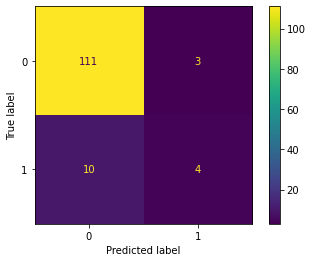

In [41]:
plot_confusion_matrix(lr, X_tuning, y_tuning, values_format = 'd')

事前にインポートしたscikit-learnの`plot_roc_curve`関数を使ってROC曲線を描画してみます。`plot_roc_curve`関数は`plot_confusion_matrix`関数と同じように
```
plot_roc_curve(学習後の分類器、予測に使うデータ、予測ターゲットのデータ)
```
のように書いて使います。

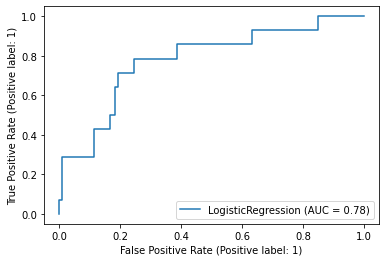

In [42]:
plot_roc_curve(lr, X_tuning, y_tuning)

## 4. チューニングデータを用いたモデルの改善

ここまでの結果を見てみると、どうも元々のデータが不均衡(Prognosis=1が少なく、Prognosis=0が多い)であるために、分類器が全てPrognosis=0と予測する方向に偏って学習してしまっているように見えます。

不均衡データの対処はweightingやサンプリングなどの方法があります。まずここではモデルの改善のためにweightingという手法を試してみることにします。

**練習問題6**：学習器を定義するときにクラスごとのサンプル数の重みを自動で付けてくれる`class_weight='balanced'`の設定を追加してみます。この設定を追加することで、数が少ないクラス(Prognosis=1)を正解することに重視して学習が進むようになります。具体的には分類器は`LogisticRegression(solver='liblinear', class_weight='balanced')`となります。この分類器を`lr_2`という名前の変数に代入して保存してください。

In [43]:
lr_2 = LogisticRegression(solver='liblinear', class_weight='balanced')

**練習問題7**：作成した分類器`lr_2`に`.fit`メソッドを使って、`X_train`、`y_train`を利用してこれまでと同じように学習をさせてください。

In [44]:
lr_2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

学習が終わった分類器`lr_2`に`.predict`メソッドを使ってチューニング用データ`X_tuning`に対して予測をしてみます。

In [45]:
lr_2.predict(X_tuning)

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

**練習問題8**：上で作成したテストデータに対する予測結果`lr_2.predict(X_tuning)`を、のちに利用するために`y_pred_lr_2`という変数に代入してください。

In [46]:
y_pred_lr_2 = lr_2.predict(X_tuning)

それぞれのスコア計算関数を使って、accuracy、precision、recall、F1 scoreを算出してください。下のセルを実行してください。

In [47]:
print(accuracy_score(y_tuning, y_pred_lr_2))    #accuracy: 正解率
print(precision_score(y_tuning, y_pred_lr_2))   #precision: 適合率（陽性的中率)
print(recall_score(y_tuning, y_pred_lr_2))      #recall: 再現率（感度）
print(f1_score(y_tuning, y_pred_lr_2))          #F1 score: 再現率と適合率の調和平均　2*Precision*Recall/(Precision + Recall)

0.75
0.2631578947368421
0.7142857142857143
0.3846153846153846


**練習問題9**：`plot_confusion_matrix`関数を使って混同行列を出力してください。`plot_confusion_matrix関数`は以下のように使うのでした。
```
plot_confusion_matrix(学習後の分類器、予測に使うデータ、予測ターゲットのデータ, values_format = 'd')
```
今回の結果を可視化するために、学習後の分類器に`lr_2`、予測に使うデータに`X_tuning`、予測ターゲットのデータに`y_tuning`を設定して実行してください。

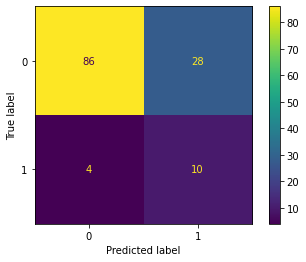

In [48]:
plot_confusion_matrix(lr_2, X_tuning, y_tuning, values_format = 'd')

**練習問題10**：`plot_roc_curve`関数を使ってROC曲線を出力してください。`plot_roc_curve`関数は以下のように使うのでした。
```
plot_roc_curve(学習後の分類器、予測に使うデータ、予測ターゲットのデータ)
```
学習後の分類器に`lr_2`、予測に使うデータに`X_tuning`、予測ターゲットのデータに`y_tuning`を設定して実行してください。

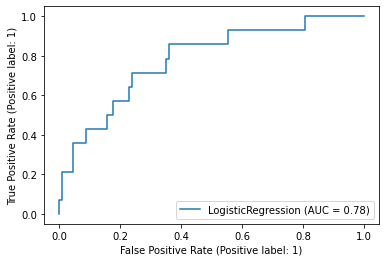

In [49]:
plot_roc_curve(lr_2, X_tuning, y_tuning)

# 実践問題

上記の2つのモデルを比べると、`class_weight='balanced'`を使った方が感度とF1スコアに優れるということがわかりました。それではlogistic regressionを使って`class_weight='balanced'`を設定してモデル作成用データ全て(`X_model`と`y_model`)を用いて学習させて、テストデータ(`X_test`と`y_test`)に対する性能を評価してみてください。

まず、モデル作成用データ全てを用いて学習するための分類器を定義します。

In [50]:
lr_act = LogisticRegression(solver='liblinear', class_weight='balanced')

**実践問題1**：上記で定義した`lr_act`を`X_model`と`y_model`を用いて学習させてください。

In [51]:
lr_act.fit(X_model, y_model)

LogisticRegression(class_weight='balanced', solver='liblinear')

**実践問題2**：学習後の`lr_act`を使って`X_test`に対して予測を行い、予測結果を`y_pred`に格納してください。

In [52]:
y_pred = lr_act.predict(X_test)

下のセルを実行し、正解率、適合率、再現率、F1スコアを出力してください。

In [53]:
print(accuracy_score(y_test, y_pred))    #accuracy: 正解率
print(precision_score(y_test, y_pred))   #precision: 適合率（陽性的中率)
print(recall_score(y_test, y_pred))      #recall: 再現率（感度）
print(f1_score(y_test, y_pred))          #F1 score: 再現率と適合率の調和平均　2*Precision*Recall/(Precision + Recall)

0.8
0.34285714285714286
0.5714285714285714
0.42857142857142855


下のセルを実行し、混同行列とROC曲線を出力してください。

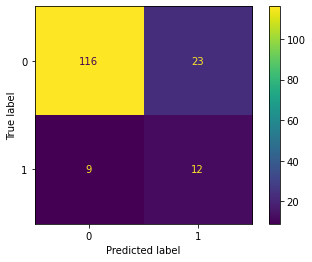

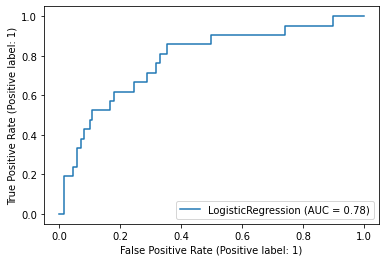

In [54]:
plot_confusion_matrix(lr_act, X_test, y_test, values_format = 'd')
plot_roc_curve(lr_act, X_test, y_test)

# 発展問題

LogisticRegression関数は`class_weight`以外にも他にも様々なオプションが指定できます。  
(参考: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html )  
オプションに`solver='liblinear'`を設定した条件のもとで、`penalty`、`C`、`class_weight`をいくつかの条件で試してみるとします。例えば、`penalty='l1'`、`C=1`、`class_weight='balanced'`のときは以下のように分類器を定義すれば良いことになります。
```
lr_tmp = LogisticRegression(solver='liblinear', penalty='l1', C=1, class_weight='balanced')
```
これらの条件を機械学習用語ではハイパーパラメータと呼びます。ハイパーパラメータは学習で得るパラメータではなく、設計者が指定する必要があるパラメータになります。ここで試してみるハイパーパラメータの条件をlist化して下のセルで定義します。

In [55]:
penalty_list = ['l1', 'l2']
C_list = [0.01, 0.1, 1, 10, 100]
class_weight_list = [None, 'balanced']

**発展問題1**：上記のリストとfor文を用い、全ての条件で分類器を作成し、それぞれの分類器で`X_train`と`y_train`を使って学習し、`X_tuning`と`y_tuning`に対するF1スコアを計算し、F1スコアを最大化する`penalty`、`C`、`class_weight`の条件を同定してください。

In [56]:
best_f1_score = 0               #ベストのF1スコアを最初0としておく
best_penalty = None             #ベストのpenaltyを最初Noneとしておく
best_C = None                   #ベストのCを最初Noneとしておく
best_class_weight = None        #ベストのclass_weightを最初Noneとしておく

for i in penalty_list:                                        #3段の入れ子にしたfor文で、全ての条件を試す
    for j in C_list:
        for k in class_weight_list:
            
            lr_tmp = LogisticRegression(solver='liblinear', penalty=i, C=j, class_weight=k)
            lr_tmp.fit(X_train, y_train)
            y_pred_tmp = lr_tmp.predict(X_tuning)
            f1_score_tmp = f1_score(y_tuning, y_pred_tmp)
            
            if best_f1_score < f1_score_tmp:                  #計算して得られたF1スコアがbest_f1_scoreより大きければ上書き
                best_f1_score = f1_score_tmp
                best_penalty = i                              #best_penalty、best_C、best_class_weightも同時に上書き
                best_C = j
                best_class_weight = k

print("best f1_score: ", best_f1_score)
print("best penalty: ", best_penalty)
print("best C: ", best_C)
print("best class_weight: ", best_class_weight)     

best f1_score:  0.4
best penalty:  l1
best C:  1
best class_weight:  None


**発展問題2**：上記で得られたF1スコアを最大化する`penalty`、`C`、`class_weight`の条件を使って、学習用データ全て(`X_model`と`y_model`)を使って学習し、`X_test`と`y_test`に対する正解率、適合率、再現率、F1スコア、混同行列、ROC曲線を出力してください。

In [57]:
lr_act = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, class_weight='balanced')
lr_act.fit(X_model, y_model)
y_pred = lr_act.predict(X_test)

In [58]:
print(accuracy_score(y_test, y_pred))    #accuracy: 正解率
print(precision_score(y_test, y_pred))   #precision: 適合率（陽性的中率)
print(recall_score(y_test, y_pred))      #recall: 再現率（感度）
print(f1_score(y_test, y_pred))          #F1 score: 再現率と適合率の調和平均　2*Precision*Recall/(Precision + Recall)

0.825
0.3870967741935484
0.5714285714285714
0.4615384615384615


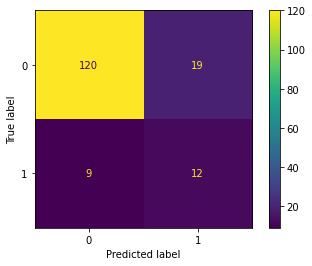

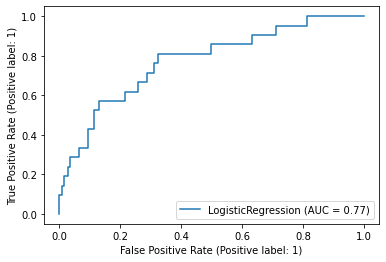

In [59]:
plot_confusion_matrix(lr_act, X_test, y_test, values_format = 'd')
plot_roc_curve(lr_act, X_test, y_test)

# 医用機械学習入門の手引きのための追記

In [60]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier()

In [61]:
dct.fit(X_train, y_train)

DecisionTreeClassifier()

In [62]:
y_pred_dct = dct.predict(X_tuning)

In [63]:
print(accuracy_score(y_tuning, y_pred_dct))    #accuracy: 正解率
print(precision_score(y_tuning, y_pred_dct))   #precision: 適合率（陽性的中率)
print(recall_score(y_tuning, y_pred_dct))      #recall: 再現率（感度）
print(f1_score(y_tuning, y_pred_dct))          #F1 score: 再現率と適合率の調和平均 2*Precision*Recall/(Precision + Recall)

0.8125
0.1875
0.21428571428571427
0.19999999999999998


In [64]:
max_depth_list = [2, 3, 4]
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 3, 4, ]
class_weight_list = [None, 'balanced']

In [65]:
param = {'max_depth':[1, 2, 3, 4, 5],
         'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
         'min_samples_split':[2, 3, 4, 5]}

In [66]:
best_max_depth = None               #ベストのF1スコアを最初0としておく
best_min_samples_leaf = None             #ベストのpenaltyを最初Noneとしておく
best_samples_split = None                   #ベストのCを最初Noneとしておく
best_class_weight = None        #ベストのclass_weightを最初Noneとしておく

for i in max_depth_list:                                        #3段の入れ子にしたfor文で、全ての条件を試す
    for j in min_samples_leaf:
        for k in min_samples_split:
            for l in best_class_weight:
            
                lr_tmp = LogisticRegression(solver='liblinear', penalty=i, C=j, class_weight=k)
                lr_tmp.fit(X_train, y_train)
            y_pred_tmp = lr_tmp.predict(X_tuning)
            f1_score_tmp = f1_score(y_tuning, y_pred_tmp)
            
            if best_f1_score < f1_score_tmp:                  #計算して得られたF1スコアがbest_f1_scoreより大きければ上書き
                best_f1_score = f1_score_tmp
                best_penalty = i                              #best_penalty、best_C、best_class_weightも同時に上書き
                best_C = j
                best_class_weight = k

print("best f1_score: ", best_f1_score)
print("best penalty: ", best_penalty)
print("best C: ", best_C)
print("best class_weight: ", best_class_weight)     

IndentationError: expected an indented block (<ipython-input-66-e26cf3806d74>, line 11)